In [1]:
import scipy.io as spio
import numpy as np

In [3]:
# This is supposed to be the Faces or Flippeds
X = spio.loadmat(file_name='../data/bci/x.mat')

In [4]:
# This is supposed to be the labels
Y = spio.loadmat(file_name='../data/bci/y.mat')

In [13]:
(X.keys(), Y.keys(), X['__globals__'], Y['__globals__'], 
 X['Intensification_Data'].shape, Y['Intensification_SType'].shape, 
X['__header__'], Y['__header__'], X['__version__'], Y['__version__'])

(dict_keys(['__globals__', 'Intensification_Data', '__header__', '__version__']),
 dict_keys(['__globals__', 'Intensification_SType', '__header__', '__version__']),
 [],
 [],
 (6480, 192, 64),
 (6480, 192),
 b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Oct 30 19:58:56 2017',
 b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Oct 30 19:59:22 2017',
 '1.0',
 '1.0')

In [17]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'] # Stimulus type

In [20]:
Data.shape, Data.dtype, SType.shape, SType.shape

((6480, 192, 64), dtype('<f8'), (6480, 192), (6480, 192))

In [26]:
# Normalizing the input data
# Visualize the mean and var/ std
mean = Data.mean(axis=0, dtype=float, keepdims=3)
mean.shape, mean.dtype

((1, 192, 64), dtype('<f8'), 12288)

In [29]:
# Std or standard deviation or square-root variance
# ddof : int, optional
# Means Delta Degrees of Freedom. 
# The divisor used in calculations is N - ddof, where N represents the number of elements. 
# By default ddof is zero.
std = Data.std(axis=0, ddof=0., dtype=float, keepdims=3)
std.shape, std.dtype

((1, 192, 64), dtype('<f8'))

In [40]:
data_norm = (Data - mean)/ std
data_norm.shape, data_norm.dtype

((6480, 192, 64), dtype('<f8'))

In [45]:
# I suggested 10% test and 90% train
# Yalda suggested 30% test and 70% train
# Let's stick 30% first which is the most pessimistic ones among the options.
# The size of training set vs the size of test set
row_test = int(data_norm.shape[0] * 0.30)

In [54]:
X_train = data_norm[:-1*row_test]
X_test = data_norm[-1*row_test:]

In [55]:
(Data.shape, data_norm.shape, X_train.shape, X_test.shape, 
 Data.dtype, data_norm.dtype, X_train.dtype, X_test.dtype)

((6480, 192, 64),
 (6480, 192, 64),
 (4536, 192, 64),
 (1944, 192, 64),
 dtype('<f8'),
 dtype('<f8'),
 dtype('<f8'),
 dtype('<f8'))

In [59]:
Y_train = SType[:-1*row_test, 0]
Y_test = SType[-1*row_test:, 0]

In [60]:
(SType.shape, Y_train.shape, Y_test.shape, 
SType.dtype, Y_train.dtype, Y_test.dtype)

((6480, 192), (4536,), (1944,), dtype('uint8'), dtype('uint8'), dtype('uint8'))

### Hyperparameters

In [62]:
mb_size = 32  # minibatch size == number of input trials
seq_len = Data.shape[1] # Number of timepoints in each trial length
n_channels = Data.shape[2] # number of channels in each trial

# Tweekable parameters
learning_rate = 1e-3
epochs = 1
keep_prob = 0.95

# GPUs availability or CPU

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [66]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers

In [53]:
with graph.as_default():
    
    # (minibatch, 192, 64) --> (minibatch, 18, 191, 64)
    #     tf.layers.conv1d(activation=, activity_regularizer=, bias_initializer=, bias_regularizer=, 
    #                      data_format=, dilation_rate=, filters=, inputs=, kernel_initializer=, 
    #                      kernel_regularizer=, kernel_size=, name=, padding=, reuse=, strides=, 
    #                      trainable=, use_bias=)
    y_conv = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                                 padding='valid', activation = tf.nn.relu)
    # tf.nn.conv1d(data_format=, filters=, name=, padding=, stride=, use_cudnn_on_gpu=, value=)
    #     y_conv = tf.nn.conv1d(data_format='NHWC', filters=[], padding=, stride=, value=inputs_)

# FC layer: 
Now, flatten and pass to the classifier

In [27]:
with graph.as_default():
    # Flatten and add dropout
    #     print(max_pool_4.shape, *max_pool_4.shape) # (?, 12, 144)
    flat = tf.reshape(max_pool_4, (-1, 12*144))
    flat = tf.nn.dropout(x=flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(inputs=flat, units=n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [32]:
import os

if (os.path.exists('checkpoints-cnn-ffnn') == False):
    !mkdir checkpoints-cnn-ffnn

In [33]:
#  Testing get_batch()
XY_train = get_batches(X_train_norm, Y_train_onehot, batch_size)
len(XY_train)
X, Y = XY_train[0]

In [35]:
valid_acc_list = []
valid_loss_list = []

train_acc_list = []
train_loss_list = []

with graph.as_default():
    saver = tf.train.Saver()

# train and valid minibatches
XY_train = get_batches(X_train_norm, Y_train_onehot, batch_size)

with tf.Session(graph=graph) as sess:
    
    # Init session variables
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs: full batch/ dataset
    for epoch in range(epochs):
        
        # Loop over minibatches
        for idx in range(len(XY_train)):
            
            # Training for minibatches of training set
            X, Y = XY_train[idx]
            feed_dict = {inputs_:X , labels_:Y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed_dict)
            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
                                        
        # Validation for all validation set
        X, Y = X_valid_norm, Y_valid_onehot
        feed_dict = {inputs_:X , labels_:Y, keep_prob_:1.0}
        valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed_dict)
        valid_acc_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
                
        # Print info in each epoch/ iteration  OR full batch
        print("Epoch: {}/{}".format(epoch+1, epochs),
              "Train loss: {:6f}".format(train_loss),
              "Train acc: {:.6f}".format(train_acc),
              "Valid loss: {:6f}".format(valid_loss),
              "Valid acc: {:.6f}".format(valid_acc))
    
    # At the end of all epochs
    saver.save(sess,"checkpoints-cnn-ffnn/bci.ckpt")

Epoch: 1/10 Train loss: 0.458018 Train acc: 0.827586 Valid loss: 0.444676 Valid acc: 0.833333
Epoch: 2/10 Train loss: 0.354878 Train acc: 0.775862 Valid loss: 0.360553 Valid acc: 0.856481
Epoch: 3/10 Train loss: 0.339282 Train acc: 0.844828 Valid loss: 0.337230 Valid acc: 0.868827
Epoch: 4/10 Train loss: 0.298143 Train acc: 0.862069 Valid loss: 0.301684 Valid acc: 0.879630
Epoch: 5/10 Train loss: 0.281424 Train acc: 0.896552 Valid loss: 0.302770 Valid acc: 0.881173
Epoch: 6/10 Train loss: 0.290232 Train acc: 0.879310 Valid loss: 0.293540 Valid acc: 0.884259
Epoch: 7/10 Train loss: 0.265929 Train acc: 0.879310 Valid loss: 0.276326 Valid acc: 0.890432
Epoch: 8/10 Train loss: 0.294277 Train acc: 0.862069 Valid loss: 0.286151 Valid acc: 0.888889
Epoch: 9/10 Train loss: 0.266821 Train acc: 0.879310 Valid loss: 0.280809 Valid acc: 0.896605
Epoch: 10/10 Train loss: 0.313059 Train acc: 0.896552 Valid loss: 0.277896 Valid acc: 0.890432


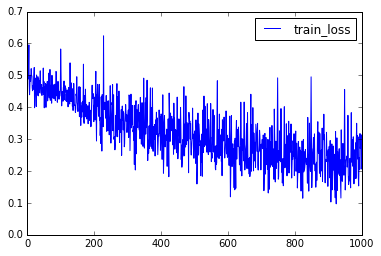

In [46]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss_list, label='train_loss')
# mplot.plot(valid_loss_list, label='valid_loss')
mplot.legend()
mplot.show()

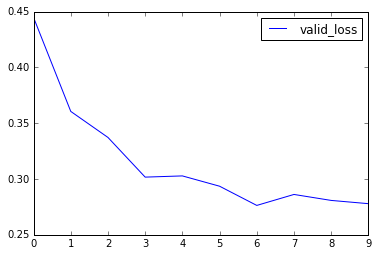

In [47]:
# import matplotlib.pyplot as mplot

# mplot.plot(train_loss_list, label='train_loss')
mplot.plot(valid_loss_list, label='valid_loss')
mplot.legend()
mplot.show()

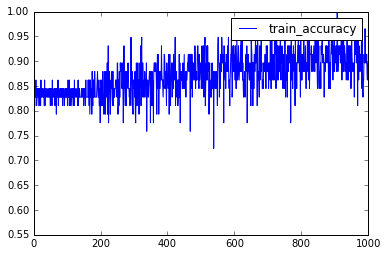

In [49]:
mplot.plot(train_acc_list, label='train_accuracy')
mplot.legend()
mplot.show()

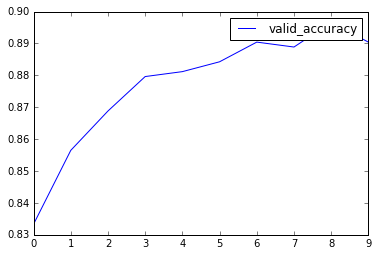

In [50]:
mplot.plot(valid_acc_list, label='valid_accuracy')
mplot.legend()
mplot.show()